In [586]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, f_regression

In [587]:
PATH_CODED_IDS_TRAIN = "data/users/coded_ids_labels_train.csv"
PATH_CODED_IDS_TEST = "data/users/coded_ids_labels_test.csv"
PATH_FEATURES = "data/users_features/features.csv"
PATH_CODED = "data/users/coded_ids.csv"

In [588]:
report_users = pd.read_csv(PATH_CODED_IDS_TEST)
coded_ids = pd.read_csv(PATH_CODED)
train_users = pd.read_csv(PATH_CODED_IDS_TRAIN)
features = pd.read_csv(PATH_FEATURES)
print("number of elements in train : " , len(train_users))

number of elements in train :  686


## Plot of spam/legit pie chart

118
568


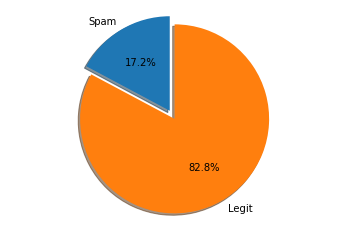

In [589]:
spam_counter = 0
legit_counter = 0
train_len = len(train_users)
for i in train_users[:]['label']:
    if i == 1:
        spam_counter += 1
    else:
        legit_counter += 1
print(spam_counter)
print(legit_counter)

labels = 'Spam', 'Legit'
pie_sizes = [100 / train_len * spam_counter, 100 / train_len * legit_counter]
fig1, ax1 = plt.subplots()
ax1.pie(pie_sizes, explode=(0.1, 0), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

## Data preprocessing

In [590]:
#NaN clearing
# print(features.dtypes.to_string(max_rows=10000))
(value_nan, features_nan) = np.where(pd.isnull(features))
features_nan = list(dict.fromkeys(features_nan))

print("columns with NaN deleted : ", list(features.columns[features_nan]))

#Removing of NaN containing columns
features = features.drop(list(features.columns[features_nan]), axis=1)

#Object features clearing
features = features.select_dtypes(exclude=[object])
print('number of features : ', len(features.columns))
print('number of object type features : ', len(features.dtypes[features.dtypes == object]))

#Setting values type to float64
features = features.apply(pd.to_numeric).astype('float64')

columns with NaN deleted :  ['spam_in_screen_name', 'time_zone', 'utc_offset']
number of features :  135
number of object type features :  0


## Joining tables and splitting train/test

In [591]:
features_ids = pd.merge(features, coded_ids, on='user_id')
features = pd.merge(features_ids, train_users, on='coded_id')
report_features = pd.merge(features_ids, report_users, on='coded_id')

X = features.loc[:, features.columns != 'label']
#Removing user_id and coded_id
X = X.iloc[:, :-2]
y = features.loc[:, 'label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=40
)

## Plot of the best features

d:\python\3.9.1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Index(['active_tweeting_frequency_per_day', 'adjusted_nb_of_uses_of_hashtag',
       'adjusted_nb_of_uses_of_mention', 'adjusted_nb_of_uses_of_sources',
       'adjusted_nb_of_uses_of_url', 'age', 'avg_intertweet_times_seconds',
       'content_duration_days', 'default_profile', 'default_profile_image',
       ...
       'temporal_bin_5', 'temporal_bin_6', 'temporal_bin_7',
       'time_since_newest_tweet_days', 'time_since_newest_tweet_months',
       'tweeting_frequency_per_day', 'tweets_with_at_top_20',
       'tweets_with_hashtags_top_20', 'tweets_with_urls_top_20',
       'urls_used_on_average'],
      dtype='object', length=134)
[5.62386738e-03 6.18032241e-03 1.02771071e-02 1.38122824e-02
 1.55172295e-02 7.19374069e-02 8.47669730e-02 1.52154464e-01
 1.63862359e-01 1.97521704e-01 3.06351002e-01 3.24518835e-01
 3.97896881e-01 5.33777668e-01 6.14905796e-01 8.99584096e-01
 9.21844542e-01 9.26460999e-01 1.00610216e+00 1.43912266e+00
 1.78731939e+00 2.42493559e+00 2.92577770e+00 3.0526

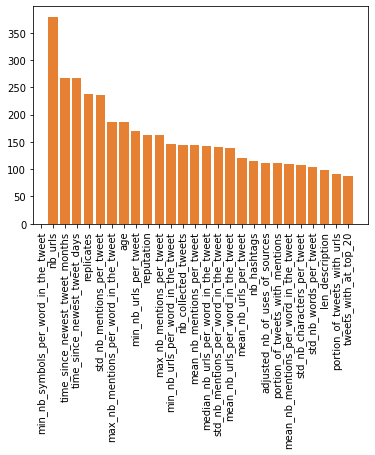

In [592]:
kb = SelectKBest(score_func=f_regression, k=10)
kb.fit(X, y)
indices = np.argsort(kb.scores_)[::-1]
selected_features = []
for i in range(30):
  selected_features.append(X.columns[indices[i]])
plt.figure()
plt.bar(selected_features, kb.scores_[indices[range(30)]], color=(0.9,0.5,0.2), align='center')
plt.xticks(rotation=90)

print(X.columns)
print(kb.scores_[np.argsort(kb.scores_[:])])
print(indices)

print(selected_features)

## LinearSVC with all non object features

In [593]:
# train_x = train_features[['nb_urls', 'time_since_newest_tweet_months']]
# test_x = test_features[['nb_urls', 'time_since_newest_tweet_months']]
# # train_x = train_features.iloc[:, :-1]
# train_y = train_features[:]['label']
# test_y = test_features[:]['label']
# print(test_features)

linearSVC = LinearSVC()
linearSVC.fit(X_train, y_train)
score = linearSVC.score(X_train, y_train)
print("final train score : ", score)


y_pred = linearSVC.predict(X_test)

test_report = classification_report(y_test, y_pred)
print(test_report)

final train score :  0.9018518518518519
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       110
           1       0.60      0.35      0.44        26

    accuracy                           0.83       136
   macro avg       0.73      0.65      0.67       136
weighted avg       0.81      0.83      0.81       136



d:\python\3.9.1\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## LinearSVC with top 5 non object features

In [594]:
linearSVC = LinearSVC()
linearSVC.fit(X_train[['median_nb_symbols_per_word_in_the_tweet', 'median_nb_symbols_per_tweet', 'min_nb_symbols_per_tweet', 'min_nb_symbols_per_word_in_the_tweet', 'nb_urls']], y_train)
score = linearSVC.score(X_train[['median_nb_symbols_per_word_in_the_tweet', 'median_nb_symbols_per_tweet', 'min_nb_symbols_per_tweet', 'min_nb_symbols_per_word_in_the_tweet', 'nb_urls']], y_train)
print("final train score : ", score)


y_pred = linearSVC.predict(X_test[['median_nb_symbols_per_word_in_the_tweet', 'median_nb_symbols_per_tweet', 'min_nb_symbols_per_tweet', 'min_nb_symbols_per_word_in_the_tweet', 'nb_urls']])

test_report = classification_report(y_test, y_pred)
print(test_report)

final train score :  0.837037037037037
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       110
           1       0.00      0.00      0.00        26

    accuracy                           0.81       136
   macro avg       0.40      0.50      0.45       136
weighted avg       0.65      0.81      0.72       136



d:\python\3.9.1\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
d:\python\3.9.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\3.9.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\3.9.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

## report prediction

In [595]:
#report_pred = linearSVC.predict(report_x)
